In [1]:
using Pkg; for p in ["MLDatasets"]; Pkg.add(p); end
import Pkg; Pkg.add("PyPlot")
using PyPlot
using Printf, Random, Test, Statistics
using MLDatasets
using Knet
import Base: length, size, iterate, eltype, IteratorSize, IteratorEltype, haslength, @propagate_inbounds, repeat, rand, tail
import .Iterators: cycle, Cycle, take
using Plots; default(fmt=:png,ls=:auto)
import CUDA # functional
array_type=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})
using Knet: Knet, dir, accuracy, progress, sgd, load, save, gc, Param, KnetArray, Data, minibatch, nll, relu, training, dropout # param, param0, xavier_uniform
using IterTools: ncycle, takenth
using Base.Iterators: flatten

   Updating registry at `C:\Users\Ahmed Imam Shah\.julia\registries\General`
  Resolving package versions...
No Changes to `C:\Users\Ahmed Imam Shah\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\Ahmed Imam Shah\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\Ahmed Imam Shah\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\Ahmed Imam Shah\.julia\environments\v1.5\Manifest.toml`


In [2]:
using Knet: sigm

In [3]:
# load full training set
train_x, train_y = MNIST.traindata();

# load full test set
test_x,  test_y  = MNIST.testdata();

size(train_x), size(train_y), size(test_x), size(test_y)

((28, 28, 60000), (60000,), (28, 28, 10000), (10000,))

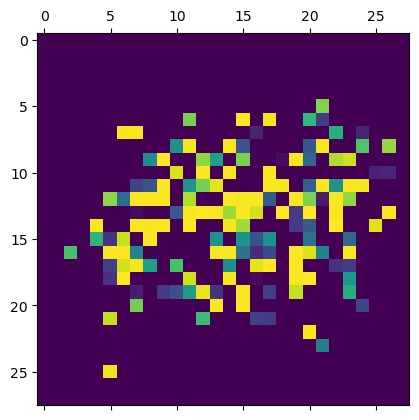

┌ Warning: Knet.seed!() is deprecated, please use Random.seed!() and/or CUDA.seed!() instead
└ @ Knet.KnetArrays C:\Users\Ahmed Imam Shah\.julia\packages\Knet\OYNCT\src\knetarrays\random.jl:14


PyObject <matplotlib.image.AxesImage object at 0x000000003AF1C070>

In [4]:
"""
    predictPixel(image)

predicts the value of the pixel based on the previous pixel values
The pixels in the input image given as the parameter will be used to predict the pixel.
This function will return the probabilities of the functions that will be used to calculate the loss.
"""
function predictPixel(image, i, j)
    random_index = rand(1:60000,size(image));
    randPixel = train_x[i,j,random_index[i,j]]
end

"""
    generateImage()

uses `predictPixel` function recursively to generate entire image.

"""
function generateImage()
    img = zeros(28,28);
    for i in 1:28
        for j in 1:28
            img[i,j] = predictPixel(img, i, j)
        end
    end
    return img;
end

Knet.seed!(2)
image=generateImage()

matshow(image)

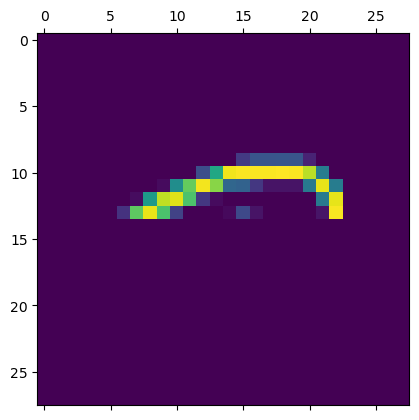

PyObject <matplotlib.image.AxesImage object at 0x000000003B5651C0>

In [5]:
"""
    occlude(image, n_rows)

Creates occluded image by assigning zeros to image rows - n_rows
"""
function occlude(image, n_rows)
    i_size = size(image)
    zero = zeros(i_size[1]-n_rows, i_size[2])
    occluded = vcat(image[1:n_rows,:], zero)
    return occluded
end

function occlude_data(data, n_rows)
    i_size = size(data)
    zero = zeros(i_size[1]-n_rows, i_size[2], i_size[3])
    occluded_data = vcat(data[1:n_rows,:,:], zero)
    return occluded_data
end


true_image = train_x[:,:,1]
occludedimg = occlude(true_image, 14)

occluded_data = occlude_data(train_x, 14)
matshow(occluded_data[:,:,19])

In [6]:
# Load MNIST data
xtrn,ytrn = MNIST.traindata(Float32); ytrn[ytrn.==0] .= 10
xtst,ytst = MNIST.testdata(Float32);  ytst[ytst.==0] .= 10

ytrn = xtrn[14+1:end,:,:]
ytrn = reshape(ytrn,(392,60000))

ytst = xtst[14+1:end,:,:]
ytst = reshape(ytst,(392,10000))

xtrn = occlude_data(xtrn,14)
xtst = occlude_data(xtst,14)

dtrn = minibatch(xtrn, ytrn, 100; xsize = (784,:))
dtst = minibatch(xtst, ytst, 10000; xsize = (784,:));

In [7]:
typeof(ytrn)

Array{Float32,2}

In [8]:
predict(w,x) = w[1]*x .+ w[2]

loss(w,x,y) = 1/(2*length(y)) .* sum(abs2.(y - predict(w,x)))

loss (generic function with 1 method)

In [9]:
lossgradient = grad(loss)

(::AutoGrad.var"#gradfun#7"{AutoGrad.var"#gradfun#6#8"{typeof(loss),Int64,Bool}}) (generic function with 1 method)

In [18]:
function mse(predictions, targets)
    N = length(targets)
    y = 1/(2*N) * sum((predictions .- targets).^2)
    return y
end

mse (generic function with 1 method)

In [19]:
function train(w, data; lr=.1)
    for (x,y) in data
        dw = lossgradient(w, x, y)
        for i in 1:length(w)
            w[i] -= lr * dw[i]
        end
    end
    return w
end

train (generic function with 1 method)

In [20]:
weight = Any[randn(392,784),randn(392)]
trainx = reshape(xtrn, (784,60000))
testx = reshape(xtst, (784,10000))

epoch = 10
train_loss = zeros(10)
test_loss = zeros(10)

for i=1:epoch
    train(weight, dtrn)
    predicted_trainx = convert(Array{Float32}, weight[1]*trainx .+ weight[2])
    predicted_testx = convert(Array{Float32}, weight[1]*testx .+ weight[2])
    train_loss[i] = mse(predicted_trainx,ytrn)
    test_loss[i] = mse(predicted_testx,ytst)
end
#predicted_data = reshape(predicted_data,(14,28,60000))

In [27]:
println(train_loss)
println(test_loss)

[8.529287074829933, 6.70241768707483, 5.569369727891157, 4.805308843537415, 4.260776190476191, 3.8530649659863947, 3.5348088435374154, 3.277861224489796, 3.0648115646258507, 2.8844333333333334]
[8.489983673469387, 6.652029081632652, 5.516705102040816, 4.752209183673469, 4.208001785714285, 3.8009785714285713, 3.483597704081632, 3.2276285714285713, 3.015617602040816, 2.8363117346938775]


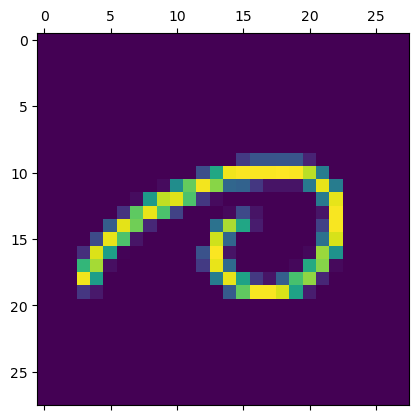

PyObject <matplotlib.image.AxesImage object at 0x000000003BED37C0>

In [37]:
#training data sample image
true_image = train_x[:,:,19]
matshow(true_image)

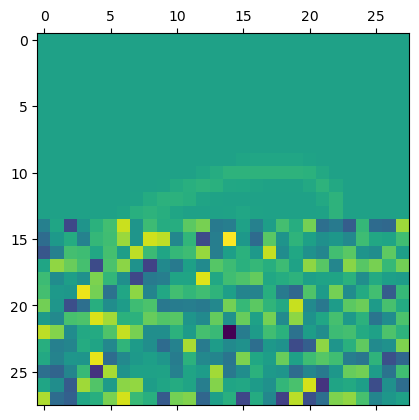

PyObject <matplotlib.image.AxesImage object at 0x000000003B5C16D0>

In [31]:
predicted_trainx = convert(Array{Float32}, weight[1]*trainx .+ weight[2])
predicted_data = reshape(predicted_trainx,(14,28,60000));

sample = vcat(occluded_data[1:14,:,19], predicted_data[:,:,19])
#occluded_data = occlude_data(train_x, 14)
matshow(sample)

In [35]:
# For running experiments
function trainresults(model; o...)
    for x in takenth(progress(sgd!(model,ncycle(dtrn,100))),length(dtrn))
        r = (model(dtrn), model(dtst))
    end
    r = reshape(collect(Float32,flatten(r)),(4,:))
    GC.gc(true) # To save gpu memory

    println(minimum(r,dims=2))
    return r
end

trainresults (generic function with 1 method)

In [32]:
# Let's define a chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = mse(c(x),y)
(c::Chain)(d::Data) = mean(c(x,y) for (x,y) in d)

# Using nonlinearities between layers results in a model with higher capacity and helps underfitting
# relu(x)=max(0,x) is a popular function used for this purpose, it replaces all negative values with zeros.
struct Layer; w; b; f; end
Layer(i::Int,o::Int,f=sigm) = Layer(randn(o,i),randn(o),f)
(l::Layer)(x) = l.f.(l.w * x .+ l.b)


In [ ]:
@doc nll